# Part 1 - Wordle Game

In [1]:
import pandas as pd
import numpy as np
import random
from termcolor import colored

## Codes to setup the game

In [2]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load files into dataframe
full_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/combined_wordlist.txt', sep=" ", header=None)
allowed_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/official_allowed_guesses.txt', sep=" ", header=None)
real_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/shuffled_real_wordles.txt', sep=" ", header=None)

In [ ]:
# Upload file manually
"""
# Run this multiple times to upload all files
from google.colab import files
uploaded = files.upload()
"""

In [ ]:
# Load files into dataframe, if uploaded manually
"""
# Load files into dataframe
full_df = pd.read_csv('combined_wordlist.txt', sep=" ", header=None)
real_df = pd.read_csv('shuffled_real_wordles.txt', sep=" ", header=None)
allowed_df = pd.read_csv('official_allowed_guesses.txt', sep=" ", header=None)
"""

In [4]:
# Convert dataframes into list
full_list = full_df[0].values.tolist()
allowed_list = allowed_df[0].values.tolist()
real_list = real_df[0].values.tolist()

# Global variables
# Use global because it's easier to update them rather than passing outputs around
global alphabet
global guess
global result

# Use escape word to quit game before attempts are used up
escape_word = 'gameover'

# Set random state
global_random_state = 1

In [5]:
# Set alphabet, which is displayed for available choices
def reset_alphabet():
    global alphabet
    alphabet = {'a': 'white', 'b': 'white', 'c': 'white', 'd': 'white', 'e': 'white', 'f': 'white', 'g': 'white',
                'h': 'white', 'i': 'white', 'j': 'white', 'k': 'white', 'l': 'white', 'm': 'white', 'n': 'white',
                'o': 'white', 'p': 'white', 'q': 'white', 'r': 'white', 's': 'white', 't': 'white',
                'u': 'white', 'v': 'white', 'w': 'white', 'x': 'white', 'y': 'white', 'z': 'white'}


# Ask for input
def ask_input():
    global guess
    
    while True:
        guess = input('Enter a 5 letters word: ').lower()

        # Secret escape word can be accepted
        if guess == escape_word:
            break
        # Only accept word within full_list
        elif guess not in full_list:
            print('Invalid input. ', end='')
        else:
            break


# Verify input and display result
def verify_input(answer, guess, output=False, printout=True):
    result = ['grey'] * 5                       # Initialize result

    answer_list = []                            # Initialize answer, to help deal with duplicate letters
    for n in answer:
        answer_list.append(n)

    for i in range(5):                          # First loop for green
        cur = guess[i]
        if cur == answer[i]:                    # If letter is a match
            result[i] = 'green'                 # Display this letter in result as green
            alphabet[cur] = 'green'             # Display this letter in alphabet as green
            answer_list.remove(cur)             # Remove this letter in answer_list, to remove duplicate for yellow check

    for i in range(5):                          # Second loop for yellow and grey
        cur = guess[i]
        if cur in (answer_list):                # If match with answer_list, which has matched letter removed
            if result[i] != 'green':            # Only update result to yellow, if it's not already green
                result[i] = 'yellow'
                answer_list.remove(cur)         # Similar to above, remove this letter in answer_list
            if alphabet[cur] != 'green':        # Only update alphabet to yellow, if it's not already green
                alphabet[cur] = 'yellow'
        if cur not in answer:                   # If no match with original answer
            alphabet[cur] = 'grey'              # Display this letter in alphabet as grey

    # Show guess result in color
    if printout:                                # Printout will be false during simulation
        for i in range(5):
            if result[i] in ('green', 'grey'):
                print(colored(guess[i], 'white', 'on_'+result[i], attrs=['bold']), end='')
            else:
                print(colored(guess[i], 'grey', 'on_'+result[i], attrs=['bold']), end='')
        print()

    # Show available letters of alphabet in color
    if printout:                                # Printout will be false during simulation
        print('Available letters: ', end='')
        for k, v in alphabet.items():
            if v in ('green', 'grey'):
                print(colored(k, 'white', 'on_'+v, attrs=['bold']), end='')
            else:
                print(colored(k, 'grey', 'on_'+v, attrs=['bold']), end='')
        print()

    # Return output in numeric format, which is used in solver
    if output:
        for i, n in enumerate(result):
            if n == 'grey':
                result[i] = 0
            elif n == 'yellow':
                result[i] = 1
            elif n == 'green': 
                result[i] = 2
        return result


# Play game with limited attempts
def wordle_game(max_try=6):
    answer = random.choice(real_list)           # Random word each game
    reset_alphabet()
    attempt = 0

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)
        ask_input()

        if guess == escape_word:                # If guess is secret escape word, end game with loss
            attempt = max_try
        else:
            verify_input(answer, guess)

            if guess != answer:
                attempt += 1
            else:
                print('You win!')
                attempt = max_try + 1
                break

    if attempt == max_try:
        print('You lost, the answer is \'', answer, '\'.')


## Play a game

In [ ]:
# Play game
wordle_game()

Attempt  1 / 6
Enter a 5 letters word: tares
tares
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  2 / 6
Enter a 5 letters word: shaky
shaky
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  3 / 6
Enter a 5 letters word: soars
soars
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  4 / 6
Enter a 5 letters word: solar
solar
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  5 / 6
Enter a 5 letters word: sonar
sonar
Available letters: abcdefghijklmnopqrstuvwxyz
You win!


# Part 2 - Wordle Solver using Information Gain
Provide suggestions solely on maximizing information gain

In [6]:
import itertools
import math
import csv
from tqdm import tqdm

## Codes to get information gain

In [7]:
# Create result_matrix
# It contains all possible combinations of guess results:
# grey - 0
# yellow - 1
# green - 2
result_matrix = list(itertools.product([0, 1, 2], repeat=5))
print(len(result_matrix))
print(result_matrix)

243
[(0, 0, 0, 0, 0), (0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 0, 1, 2), (0, 0, 0, 2, 0), (0, 0, 0, 2, 1), (0, 0, 0, 2, 2), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 0, 2), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 0, 1, 1, 2), (0, 0, 1, 2, 0), (0, 0, 1, 2, 1), (0, 0, 1, 2, 2), (0, 0, 2, 0, 0), (0, 0, 2, 0, 1), (0, 0, 2, 0, 2), (0, 0, 2, 1, 0), (0, 0, 2, 1, 1), (0, 0, 2, 1, 2), (0, 0, 2, 2, 0), (0, 0, 2, 2, 1), (0, 0, 2, 2, 2), (0, 1, 0, 0, 0), (0, 1, 0, 0, 1), (0, 1, 0, 0, 2), (0, 1, 0, 1, 0), (0, 1, 0, 1, 1), (0, 1, 0, 1, 2), (0, 1, 0, 2, 0), (0, 1, 0, 2, 1), (0, 1, 0, 2, 2), (0, 1, 1, 0, 0), (0, 1, 1, 0, 1), (0, 1, 1, 0, 2), (0, 1, 1, 1, 0), (0, 1, 1, 1, 1), (0, 1, 1, 1, 2), (0, 1, 1, 2, 0), (0, 1, 1, 2, 1), (0, 1, 1, 2, 2), (0, 1, 2, 0, 0), (0, 1, 2, 0, 1), (0, 1, 2, 0, 2), (0, 1, 2, 1, 0), (0, 1, 2, 1, 1), (0, 1, 2, 1, 2), (0, 1, 2, 2, 0), (0, 1, 2, 2, 1), (0, 1, 2, 2, 2), (0, 2, 0, 0, 0), (0, 2, 0, 0, 1), (0, 2, 0, 0, 2), (0, 2, 0, 1, 0), (0, 2, 0,

In [8]:
# Get possible words based on green
def check_green(letter, position, current_possible):
    new_possible = []
    for word in current_possible:
        if letter == word[position]:
            new_possible.append(word)
            # Update remaining position
    return new_possible


# Get possible words based on yellow
# remaining_pos for yellow excludes green position, and current yellow position
def check_yellow(letter, position, remaining_pos, current_possible):
    new_possible = []
    for word in current_possible:
        if letter != word[position]:                                # No match on yellow's position
            for i in remaining_pos:                                 # Check all remaining position
                if letter == word[i]:                               # Look for match
                    new_possible.append(word)
    new_possible = list(set(new_possible))                          # Convert to set then back to list to only keep unique
    return new_possible


# Get possible words based on grey
# remaining_pos for grey excludes green position; if a letter alread appeared, remaining_pos = position
def check_grey(letter, position, remaining_pos, current_possible):
    new_possible = []
    for word in current_possible:
        keep = True                                                 # Set keep to True, assuming we keep this word
        for i in remaining_pos:
            if letter == word[i]:                                   # If a letter is matched in remaining position
                keep = False                                        # Set keep to False
        if keep == True:                                            # Only add to list if keep is True
            new_possible.append(word)
    return new_possible


# Combine the 3 functions from above
# Get possible words based on result
def get_possible_words(guess, result, current_possible):
    new_possible = current_possible
    remaining_pos = list(range(5))
    appeared_yellow = []

    # Green
    for i in range(5):
        if result[i] == 2:
            new_possible = check_green(guess[i], i, new_possible)
            remaining_pos.remove(i)

    # Yellow
    for i in range(5):
        if result[i] == 1:
            temp_remaining_pos = [x for x in remaining_pos if x != i]                           # Need to ignore current yellow from remaining_pos
            new_possible = check_yellow(guess[i], i, temp_remaining_pos, new_possible)
            appeared_yellow.append(guess[i])

    # Grey
    for i in range(5):
        if result[i] == 0:
            if guess[i] in appeared_yellow:                                                     # If a letter is grey but already appeared as yellow, it just means it's not appearing at its current position
                new_possible = check_grey(guess[i], i, [i], new_possible)                       # So only check it on its exact positions
            else:
                new_possible = check_grey(guess[i], i, remaining_pos, new_possible)

    return new_possible

In [9]:
# Measure a word with result_matrix, show all details
# Note, this isn't used in wordle_solver, but it helps explain how information gain is calculated
def measure_guess_gain_detail(guess, current_possible):
    word_list = []
    result_list = []
    possible_count_list = []
    removed_count_list = []
    probability_list = []
    gain_list = []

    for result in result_matrix:
        word_list.append(guess)
        result_list.append(result)

        possible_word = get_possible_words(guess, result, current_possible)

        possible_count_list.append(len(possible_word))

        removed = len(current_possible) - len(possible_word)
        removed_count_list.append(removed)

        probability = len(possible_word) / len(current_possible)
        probability_list.append(probability)

        # Gain is calculated using probability of this result * information gain of using this result
        if probability != 0:
            gain_list.append(probability * math.log2(1/probability))
        else: gain_list.append(0)

    output_df = pd.DataFrame({
        'Guess': word_list,
        'Result': result_list,
        'Possible Count': possible_count_list,
        'Removed Count': removed_count_list,
        'Result Possibility': probability_list,
        'Information Gain': gain_list
    })


    return output_df

In [40]:
# Look at detail of gain for a word
pd.set_option('display.width', 150)
print(measure_guess_gain_detail('tares', full_list))
print(measure_guess_gain_detail('tares', full_list)['Information Gain'].sum())

     Guess           Result  Possible Count  Removed Count  Result Possibility  Information Gain
0    tares  (0, 0, 0, 0, 0)             858          12114            0.066142          0.259165
1    tares  (0, 0, 0, 0, 1)             296          12676            0.022818          0.124444
2    tares  (0, 0, 0, 0, 2)             814          12158            0.062751          0.250640
3    tares  (0, 0, 0, 1, 0)             637          12335            0.049106          0.213510
4    tares  (0, 0, 0, 1, 1)             213          12759            0.016420          0.097344
..     ...              ...             ...            ...                 ...               ...
238  tares  (2, 2, 2, 1, 1)               0          12972            0.000000          0.000000
239  tares  (2, 2, 2, 1, 2)               0          12972            0.000000          0.000000
240  tares  (2, 2, 2, 2, 0)               1          12971            0.000077          0.001053
241  tares  (2, 2, 2, 2, 1)   

In [11]:
# Measure a word with result_matrix, just show information gain
def measure_guess_gain(guess, current_possible):
    gain_list = []

    for result in result_matrix:
        possible_word = get_possible_words(guess, result, current_possible)

        probability = len(possible_word) / len(current_possible)

        # Gain is calculated using probability of this result * information gain
        if probability != 0:
            gain_list.append(probability * math.log2(1/probability))

    return sum(gain_list)

In [12]:
# Look at information gain for a word
print(measure_guess_gain('slate', full_list))

5.871215373158408


## Generate recommendation for 1st guess
- Only need to run these codes onces
- In the future, just load the csv or pick a word from result
- This is to save time

In [ ]:
# These codes only need to be ran once, because the output is saved into a CSV
"""
with open('1st_guess_info_gain.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for word in tqdm(full_list):
        word_gain = measure_guess_gain(word, full_list)
        writer.writerow([word, word_gain])
"""

100%|██████████| 12972/12972 [1:51:05<00:00,  1.95it/s]


In [13]:
# Load guess information gain file
guess1_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/1st_guess_info_gain.csv')

# Load files into dataframe, if uploaded manually
# guess1_gain_df = pd.read_csv('1st_guess_info_gain.csv')

# Rename "Score" into "IG Score" (Information Gain Score)
guess1_gain_df = guess1_gain_df.rename(columns={"Score": "IG Score"})

# Get top 10 list
top10_guess1_df = guess1_gain_df.sort_values(by='IG Score', ascending=False)[0:10]
top10_guess1_df

,Word,IG Score
103,tares,6.194053
9267,lares,6.149919
6646,rales,6.114343
1202,rates,6.096243
7529,teras,6.076619
6625,nares,6.066831
12250,soare,6.061395
9592,tales,6.054988
11871,reais,6.049778
783,tears,6.032339


## Codes to run Wordle Solver

In [14]:
# Measure information gain for all possible guesses
def measure_guess_gain_list(guess_list, current_possible):
    word_list = []
    gain_list = []

    for word in tqdm(guess_list):                                                               # This part takes awhile, so show a progress bar
        word_list.append(word)
        gain_list.append(measure_guess_gain(word, current_possible))

    output_df = pd.DataFrame({
        'Word': word_list,
        'Score': gain_list
    })

    output_df = output_df.sort_values(by='Score', ascending=False)

    return output_df


# Ask for input
def ask_input_solver(status):
    while True:
        global guess
        global result

        if status == 'guess':
            message = 'Which word did you guess? '

            guess = input(message).lower()
        
            # Secret escape word can be accepted
            if guess == escape_word:
                break
            # Only accept word within full_list
            elif guess not in full_list:
                print('Invalid input. ', end='')
            else:
                break

        elif status == 'result':
            message = 'What is the result? '

            result = input(message)
            if result == escape_word:
                guess = escape_word
                break
            else:
                try:
                    result = tuple([int(a) for a in str(result)])           # Wrap input result in a tuple, to match result_matrix
                    if result not in result_matrix:                         # If input result is not within result matrix
                        print('Invalid input. ', end='')
                    else:
                        break
                except:
                    print('Invalid input. ', end='')


# Solve a game with limited attempts
def wordle_solver(max_try=6):
    attempt = 0
    prev_possible = full_list

    print('Top 10 recommended 1st guess:')
    print(top10_guess1_df.to_string(index=False))

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)

        ask_input_solver('guess')
        if guess == escape_word:                # If guess is secret escape word, end session
            attempt = max_try
            break
        
        ask_input_solver('result')
        if result == escape_word:               # If result is secret escape word, end session
            attempt = max_try
            break

        if result == (2, 2, 2, 2, 2):
            print('You won!')
            attempt = max_try + 1
            break
        else:
            curr_possible = get_possible_words(guess, result, prev_possible)
            curr_gain = measure_guess_gain_list(curr_possible, curr_possible)
            
            print('# of words remaining', len(curr_possible))
            print('Top 10 recommended guess:')
            print(curr_gain[0:10].to_string(index=False))
            print('-' * 30)

            # Prepare for next loop
            prev_possible = curr_possible
            attempt += 1

    if attempt >= max_try:
        print('Game Over')

## Solve a game

When prompted to enter result, use numbers to represent color.

- 0 = Grey

- 1 = Yellow

- 2 = Green


For example, the word below would be 20010.

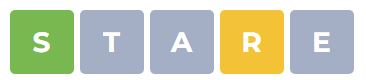

In [37]:
# Result color code: Grey=0, Yellow=1, Green=2
# Example: 01002, if second letter is yellow and last letter is green
wordle_solver()

Top 10 recommended 1st guess:
 Word  IG Score
tares  6.194053
lares  6.149919
rales  6.114343
rates  6.096243
teras  6.076619
nares  6.066831
soare  6.061395
tales  6.054988
reais  6.049778
tears  6.032339
Attempt  1 / 6
Which word did you guess? tares
What is the result? 10011


100%|██████████| 96/96 [00:00<00:00, 138.74it/s]


# of words remaining 96
Top 10 recommended guess:
 Word    Score
sente 6.106118
stept 6.083382
stent 5.843787
suete 5.695349
styte 5.600700
steme 5.082155
stele 5.081460
stede 5.014712
geste 4.963633
egest 4.667513
------------------------------
Attempt  2 / 6
Which word did you guess? sente
What is the result? 12020


100%|██████████| 8/8 [00:00<00:00, 290.97it/s]


# of words remaining 8
Top 10 recommended guess:
 Word    Score
pesty 1.811278
pesto 1.548795
yesty 1.405639
festy 1.405639
zesty 1.405639
besti 1.061278
mesto 1.061278
cesti 1.061278
------------------------------
Attempt  3 / 6
Which word did you guess? pesty
What is the result? 02222


100%|██████████| 3/3 [00:00<00:00, 292.10it/s]


# of words remaining 3
Top 10 recommended guess:
 Word    Score
yesty 0.918296
festy 0.918296
zesty 0.918296
------------------------------
Attempt  4 / 6
Which word did you guess? yesty
What is the result? 02222


100%|██████████| 2/2 [00:00<00:00, 311.38it/s]


# of words remaining 2
Top 10 recommended guess:
 Word  Score
festy    1.0
zesty    1.0
------------------------------
Attempt  5 / 6
Which word did you guess? festy
What is the result? 02222


100%|██████████| 1/1 [00:00<00:00, 286.36it/s]


# of words remaining 1
Top 10 recommended guess:
 Word  Score
zesty    0.0
------------------------------
Attempt  6 / 6
Which word did you guess? zesty
What is the result? 22222
You won!
Game Over


# Part 3 - Wordle Solver with Machine Learning Added

## Cleaning and Feature Engineering

Create ML_df which is full list of words with extra details used for ML

In [15]:
# Create ML_df
ML_df = full_df.copy()
ML_df.columns = ['word']                                     # Add header so it can be joined (merged) on this column
print(ML_df.shape)
ML_df.head()

(12972, 1)


,word
0,noles
1,melas
2,waist
3,ohias
4,mummy


### Add a column for Answer

- This will be a boolean showing whether the word was used as answer before
- This column will be used as output(y) in ML models

In [16]:
# Update answer column on ML_df, showing if the word was used as answer
answer_check = ML_df['word'].isin(real_list)
ML_df['answer'] = answer_check.astype(int)                      # Convert bool to int

# Double check that we have the correct number of answer set to 1 or True
print(len(real_list))
print(sum(ML_df['answer']))

print(ML_df.shape)
ML_df.head()

2315
2315
(12972, 2)


,word,answer
0,noles,0
1,melas,0
2,waist,1
3,ohias,0
4,mummy,1


### Add a column for Word Frequency

- This column uses the number of count for this word as frequency
- Source: https://www.kaggle.com/rtatman/english-word-frequency?select=unigram_freq.csv
- This column will be used as one of the inputs(X) in the ML models

In [17]:
from sklearn import preprocessing

# Load word frequency file
freq_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/unigram_freq.csv')
print(freq_df.shape)

# Only keep words in wordle full list
freq_wordle_df = freq_df.loc[freq_df['word'].isin(full_list)]
print(freq_wordle_df.shape)

# Add new column to ML_df, showing frequency
ML_df = pd.merge(ML_df, freq_wordle_df, on='word', how='left')
ML_df['count'] = ML_df['count'].fillna(0)                     # Replace NaN with 0

# Add new column to ML_df, showing normalized frequency
count_norm = preprocessing.normalize([ML_df['count']])
ML_df['count_norm'] = count_norm[0]

print(ML_df.shape)
ML_df.head()

(333333, 2)
(8092, 2)
(12972, 4)


,word,answer,count,count_norm
0,noles,0,55380.0,0.000015
1,melas,0,64255.0,0.000018
2,waist,1,5013500.0,0.001391
3,ohias,0,0.0,0.000000
4,mummy,1,1878933.0,0.000521


### Add a column for Base Form

- This will be a boolean showing if the word is in its base form
- I hypothesized that plural forms and past tense words will less likely be picked as answer
- If this is confirmed, then the number of likely guesses can be reduced
- This column will be used as one of the inputs(X) in the ML models

In [20]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Save the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

# Create list of lemmatized singular words (for noun) from full_list
singular_words = []
for word in full_list:
    if word == wordnet_lemmatizer.lemmatize(word, 'n'):
        singular_words.append(word)

# Create list of lemmatized present tense words (for verb) from full_list
present_words = []
for word in full_list:
    if word == wordnet_lemmatizer.lemmatize(word, 'v'):
        present_words.append(word)

# Add new column to ML_df, showing if the word is in singular form (for noun)
singular_check = ML_df['word'].isin(singular_words)
ML_df['singular'] = singular_check.astype(int)                          # Convert bool to int

# Add new column to ML_df, showing if the word is in present form (for verb)
present_check = ML_df['word'].isin(present_words)
ML_df['present'] = present_check.astype(int)                          # Convert bool to int

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'cigar'].to_string())
print()
print(ML_df[ML_df['word'] == 'plush'].to_string())
print()
print(ML_df[ML_df['word'] == 'meals'].to_string())              # Plural
print()
print(ML_df[ML_df['word'] == 'words'].to_string())              # Plural
print()
print(ML_df[ML_df['word'] == 'acted'].to_string())              # Past tense
print()
print(ML_df[ML_df['word'] == 'boxed'].to_string())              # Past tense
print()

print('Count of False')
print(len(ML_df[ML_df['singular'] == 0]))
print(len(ML_df[ML_df['present'] == 0]))

      word  answer      count  count_norm  singular  present
615  cigar       1  3993843.0    0.001108         1        1

        word  answer      count  count_norm  singular  present
11739  plush       1  4692870.0    0.001302         1        1

       word  answer       count  count_norm  singular  present
3331  meals       0  11515834.0    0.003195         0        1

       word  answer       count  count_norm  singular  present
4429  words       0  90910143.0    0.025222         0        0

       word  answer      count  count_norm  singular  present
1670  acted       0  4468180.0     0.00124         1        0

     word  answer      count  count_norm  singular  present
31  boxed       0  5778226.0    0.001603         1        0

Count of False
2041
1413


### Add a column for Name

- This will be a boolean showing if the word is in a name
- Source: https://github.com/hadley/data-baby-names/blob/master/baby-names.csv
- Source: https://github.com/smashew/NameDatabases/blob/master/NamesDatabases/first%20names/us.txt
- I hypothesized that words that are common names are less likely be picked as answer (this is actually false, which will be shown later)
- If this is confirmed, then the number of likely guesses can be reduced
- This column will be used as one of the inputs(X) in the ML models

In [22]:
# Load name file
name_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/common_names.txt', header=None)

# Get list of names
name_list = name_df[0]

# Convert to lower case
name_list = list(map(lambda x: x.lower(), name_list))

# Only keep words in wordle full list
name_wordle_list = [w for w in name_list if w in full_list]

# Add new column to ML_df, showing if the word is in a name
name_check = ML_df['word'].isin(name_wordle_list)
ML_df['name'] = name_check.astype(int)                          # Convert bool to int

# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'billy'].to_string())
print()
print(ML_df[ML_df['word'] == 'nancy'].to_string())
print()
print(ML_df[ML_df['word'] == 'jacky'].to_string())              # This name database doesn't have Jacky for some reason
print()
print(ML_df[ML_df['word'] == 'price'].to_string())
print()

       word  answer       count  count_norm  singular  present  name
5840  billy       1  13515249.0     0.00375         1        1     1

       word  answer       count  count_norm  singular  present  name
5152  nancy       0  13381057.0    0.003712         1        1     1

       word  answer     count  count_norm  singular  present  name
6181  jacky       0  395853.0     0.00011         1        1     0

      word  answer        count  count_norm  singular  present  name
407  price       1  501651226.0     0.13918         1        1     0



In [23]:
# Count of words that are answer and name
print('A:1, N:1')
print(ML_df[(ML_df['answer'] == 1) & (ML_df['name'] == 1)].shape[0])
print()

# Count of words that are not answer and name
print('A:0, N:1')
print(ML_df[(ML_df['answer'] == 0) & (ML_df['name'] == 1)].shape[0])
print()

# Count of words that are answer and not name
print('A:1, N:0')
print(ML_df[(ML_df['answer'] == 1) & (ML_df['name'] == 0)].shape[0])
print()

# Count of words that are not answer and not name
print('A:0, N:0')
print(ML_df[(ML_df['answer'] == 0) & (ML_df['name'] == 0)].shape[0])

A:1, N:1
86

A:0, N:1
145

A:1, N:0
2229

A:0, N:0
10512


## Feature selection

In [24]:
# Group by answer
ML_df.groupby(by='answer').mean().round(4)

,count,count_norm,singular,present,name
answer,,,,,
0,1.469030e+06,0.0004,0.8090,0.8764,0.0136
1,2.056245e+07,0.0057,0.9974,0.9585,0.0371


Words that are answer:

- tend to have a higher count
- are much more likely to be in base form (singular and present)
- are slightly more likely to be name

Feature: 0, Score: 0.68882
Feature: 1, Score: 0.27190
Feature: 2, Score: 0.02126
Feature: 3, Score: 0.01802


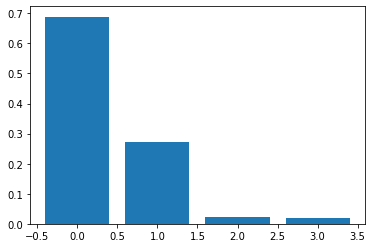

In [25]:
# Decision tree for feature importance on a regression problem
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# Define dataset
y = ML_df[['answer']]
X = ML_df[['count_norm', 'singular', 'present', 'name']]

# Define the model (give it max depth of 5, which is one more than features of X)
model = DecisionTreeRegressor(max_depth=5, random_state=global_random_state)

# Fit the model
model.fit(X, y)

# Get importance
importance = model.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# Plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In conclusion, seems like name is not a good predictor (at least with current setup). It is also shown that my hypothesis about name less likely to be answer is false.

This is verified by just looking at the mean, as well as using decision tree regressor to check feature importance.

So name column will not be selected as input feature for ML models in later sections.

Whether a word is in present tense is also not a useful predictor (surprisingly).

Reference: https://machinelearningmastery.com/calculate-feature-importance-with-python/

## ML

In [26]:
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import metrics

import warnings

### Train Test Split

In [27]:
# Load Wordle answers listed in order; this dataset differs from real_list, because real_list is in random order
answer_ordered_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/Wordle Answers.csv')

# Only take 1st 300 words, as currently these answers are known
answer_ordered_df = answer_ordered_df[0:300]

# Convert into list
answer_list = answer_ordered_df['Word'].values.tolist()

# Check
print(len(answer_list))
print(answer_list[0:5])
print()

# Add new column to ML_df, marking these 300 answers as ones we want to keep for model
in_model_check = ML_df['word'].isin(answer_list)
ML_df['in_model'] = in_model_check.astype(int)                  # Convert bool to int

# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'cigar'].to_string())
print()
print(ML_df[ML_df['word'] == 'awake'].to_string())
print()
print(ML_df[ML_df['word'] == 'heist'].to_string())              # This word is an answer, but it is for a later date, so it should have in_model == 0
print()
print(ML_df[ML_df['word'] == 'ovolo'].to_string())              # Not an answer and not in model

300
['cigar', 'rebut', 'sissy', 'humph', 'awake']

      word  answer      count  count_norm  singular  present  name  in_model
615  cigar       1  3993843.0    0.001108         1        1     0         1

       word  answer      count  count_norm  singular  present  name  in_model
7427  awake       1  3230337.0    0.000896         1        1     0         1

        word  answer     count  count_norm  singular  present  name  in_model
10442  heist       1  419629.0    0.000116         1        1     0         0

       word  answer  count  count_norm  singular  present  name  in_model
9639  ovolo       0    0.0         0.0         1        1     0         0


In [ ]:
# Find ratio of answer and full list
print('  Full list:', len(full_list))
print('Answer list:', len(real_list))

ratio = len(full_list) / len(real_list)
print('Ratio:', ratio)

# Maintain the ratio in our sample selection
# Since there is only 300 words as known answers, use 300 * 5.6 = 1680 as total sample size

# Extract 300 entries where word was used as answer, which we marked as in_model
ML_300_df = ML_df[ML_df['in_model'] == 1]
print('ML_300_df:', ML_300_df.shape)

# Extract 1380 entries where word was not used as answer
ML_1380_df = ML_df[ML_df['answer'] == 0].sample(n=1380, random_state=1)
print('ML_1380_df:', ML_1380_df.shape)

# Combine above 2 dataframes, and create the whole set of 1680 words used to run ML model
ML_1680_df = pd.concat([ML_300_df, ML_1380_df])
print('ML_1680_df:', ML_1680_df.shape)

  Full list: 12972
Answer list: 2315
Ratio: 5.603455723542116
ML_300_df: (300, 8)
ML_1380_df: (1380, 8)
ML_1680_df: (1680, 8)


In [ ]:
# Train test split
# Note, name is not selected as feature
features = ['count_norm', 'singular']

y = ML_1680_df['answer']
X = ML_1680_df[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=global_random_state)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

X_train.head()

(1512, 2)
(168, 2)
(1512,)
(168,)


,count_norm,singular
34,0.000000,1
4379,0.000000,1
12910,0.000027,1
12847,0.000000,1
11459,0.000000,1



### Model Selection

- Quickly apply multiple ML algorithms, and evaluate which performs better
- Codes are from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- However, I made some adjustments of my own


In [ ]:
"""
# These codes only need to be ran once
"""

# Both F1_score and Recall have merits to be the scoring method
# F1 score helps find a balanced result
# Recall is also good, because the point is to get as many positives as possible and false positive can be tolerated
score_method = 'f1_micro'
# score_method = 'recall'

# Turn off warnings (most warnings are about models not converging)
# Reset warnings at the end of this block
warnings.filterwarnings("ignore")

# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    # svm.NuSVC(probability=True),                                  # This is skipped because it runs into issues
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

# Split dataset in cross-validation with this splitter class
# Note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.2, train_size=.7, random_state=global_random_state)
# Run model 10x with 70/20 split intentionally leaving out 10%

# Create table to compare MLA metrics
MLA_columns = ['[MLA Name]',
               '[MLA Parameters]',
               '[MLA Train Score Mean]',
               '[MLA Test Score Mean]',
               '[MLA Test Score Mean Minus 3*STD]',
               '[MLA Time]']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = y

# Index through MLA and save performance to table
row_index = 0
for alg in MLA:
    # Set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, '[MLA Name]'] = MLA_name
    MLA_compare.loc[row_index, '[MLA Parameters]'] = str(alg.get_params())

    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, X, y, scoring=score_method, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, '[MLA Train Score Mean]'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, '[MLA Test Score Mean]'] = cv_results['test_score'].mean()

    # If this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    # Let's know the worst that can happen!
    MLA_compare.loc[row_index, '[MLA Test Score Mean Minus 3*STD]'] = cv_results['test_score'].mean() - cv_results['test_score'].std() * 3

    MLA_compare.loc[row_index, '[MLA Time]'] = cv_results['fit_time'].mean()

    # Save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)

    y = ML_1680_df['answer']      # Some models changed Y, so it is refreshed here

    row_index += 1

# Reset warnings
warnings.resetwarnings()

In [ ]:
"""
# These codes only need to be ran once
"""

# Print and sort table
MLA_compare.sort_values(by=['[MLA Test Score Mean]'], ascending=False, inplace=True)
with pd.option_context('display.max_columns', None, 'display.max_colwidth', 20):
    print(MLA_compare)
print('-' * 30)

             [MLA Name]     [MLA Parameters] [MLA Train Score Mean] [MLA Test Score Mean] [MLA Test Score Mean Minus 3*STD] [MLA Time]
0    AdaBoostClassifier  {'algorithm': 'S...             0.927891               0.912798              0.875757                0.187621
3   GradientBoosting...  {'ccp_alpha': 0....             0.947024               0.912798              0.887845                0.106718
13  KNeighborsClassi...  {'algorithm': 'a...             0.931207               0.908333              0.884442                0.003287
16  DecisionTreeClas...  {'ccp_alpha': 0....              0.98835               0.887798              0.852521                0.003586
17  ExtraTreeClassifier  {'ccp_alpha': 0....             0.989711               0.887798              0.860997                0.002861
4   RandomForestClas...  {'bootstrap': Tr...              0.98835               0.887202              0.848396                0.179983
1     BaggingClassifier  {'base_estimator...           

### Adaptive Boost Classifier (on Decision Tree)

- In terms of F1 score, best performing model is AdaBoostClassifier, bosting on decision tree
- But it's recall is not high

In [ ]:
"""
# These codes only need to be ran once
"""

# Hyper-parameter search using GridSearchCV
parameters = {'base_estimator': [tree.DecisionTreeClassifier(max_depth=2, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=3, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=4, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=5, random_state=global_random_state)],
              'n_estimators': list(range(10, 60, 10)),
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'random_state': [global_random_state]}
# Note: models such as rf_model and gb_model could be added into base_estimator

ab_gridSearch = GridSearchCV(ensemble.AdaBoostClassifier(),
                             parameters,
                             cv=5,
                             scoring='f1_micro')
ab_gridSearch.fit(X_train, y_train)
print("<<Adaptive Boost>>")
print(ab_gridSearch.best_params_)

<<Adaptive Boost>>
{'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'learning_rate': 0.01, 'n_estimators': 20, 'random_state': 1}


In [ ]:
# Build model using best_estimator_ from Grid Search
# Uncomment and use the line below if block above was ran
# ab_model = ab_gridSearch.best_estimator_

# ------------------------------------------------------------------------------

# Build model by manually inputting the best_estimator parameters
# {'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'learning_rate': 0.01, 'n_estimators': 20, 'random_state': 1}
dc_model = tree.DecisionTreeClassifier(max_depth=2, random_state=global_random_state)
ab_model = ensemble.AdaBoostClassifier(base_estimator=dc_model, learning_rate=0.01, n_estimators=20, random_state=global_random_state)

ab_model.fit(X_train, y_train)
y_train_pred = ab_model.predict(X_train)
y_valid_pred = ab_model.predict(X_valid)

# Evaluate model using prediction on training and validation set
train_score = {'Accuracy': metrics.accuracy_score(y_train, y_train_pred),
               'F1 Score': metrics.f1_score(y_train, y_train_pred),
               'Precision': metrics.precision_score(y_train, y_train_pred),
               'Recall': metrics.recall_score(y_train, y_train_pred),
               'AUC Score': metrics.roc_auc_score(y_train, y_train_pred)}
validation_score = {'Accuracy': metrics.accuracy_score(y_valid, y_valid_pred),
                    'F1 Score': metrics.f1_score(y_valid, y_valid_pred),
                    'Precision': metrics.precision_score(y_valid, y_valid_pred),
                    'Recall': metrics.recall_score(y_valid, y_valid_pred),
                    'AUC Score': metrics.roc_auc_score(y_valid, y_valid_pred)}

ab_result = pd.DataFrame({'Training Data': train_score, 'Validation Data': validation_score})
print(ab_result)

           Training Data  Validation Data
Accuracy        0.923942         0.934524
F1 Score        0.775828         0.835821
Precision       0.805668         0.848485
Recall          0.748120         0.823529
AUC Score       0.854799         0.893108


### Evaluate Model

- Now the true test, predict the whole dataset and see if it does well
- View the wrong predictions in test set, so we can get some insights on which word it gets wrong
- There is a bit of "cheating" here, by looking at all the answers for Wordle game in the future, but this is only for evaluation
- The ML model doesn't use this data, so the model itself is still honest and doesn't overfit

In [ ]:
pred = ab_model.predict(ML_df[features])

pred_result_df = ML_df.copy()
pred_result_df['pred'] = pred                                               # Add pred_proba as a column

print('Confusion Matrix')
conf_matrix = pd.DataFrame(metrics.confusion_matrix(ML_df['answer'], pred), 
                           index=['answer:False', 'answer:True'],
                           columns=['pred:False', 'pred:True'])
print(conf_matrix)
print()

print('Accuracy')
print(metrics.accuracy_score(ML_df['answer'], pred))
print()

print('F1 Score')
print(metrics.f1_score(ML_df['answer'], pred))
print()

print('Precision')
print(metrics.precision_score(ML_df['answer'], pred))
print()

print('Recall')
print(metrics.recall_score(ML_df['answer'], pred))
print()

print('Wrong Predictions')
pred_result_df[pred_result_df['pred'] != pred_result_df['answer']]

Confusion Matrix
              pred:False  pred:True
answer:False       10060        597
answer:True          657       1658

Accuracy
0.9033302497687327

F1 Score
0.7256017505470459

Precision
0.7352549889135255

Recall
0.7161987041036717

Wrong Predictions


,word,answer,count,count_norm,singular,present,name,in_model,pred
31,boxed,0,5778226.0,0.001603,1,0,0,0,1
60,posed,0,3604888.0,0.001000,1,0,0,0,1
64,yahoo,0,155733641.0,0.043207,1,1,0,0,1
66,annul,1,146490.0,0.000041,1,1,0,0,0
72,gamut,1,553397.0,0.000154,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
12909,bates,0,3503755.0,0.000972,1,0,0,0,1
12912,rhine,0,1162642.0,0.000323,1,1,0,0,1
12951,paced,0,2755521.0,0.000764,1,0,0,0,1
12959,bough,1,520067.0,0.000144,1,1,0,0,0


Use predict_proba's second number, to get probability of predictiong 'answer' (1)

predict_proba shows two classes, 0 and 1 in this case

We just need 1's probability, so add this at the end: [:, 1]

In [ ]:
# Insert pred into pred_result_df
pred_proba = ab_model.predict_proba(ML_df[features])[:, 1]

pred_result_df['pred'] = pred_proba                                         # Replace pred with pred_proba

pred_result_df.head()

,word,answer,count,count_norm,singular,present,name,in_model,pred
0,noles,0,55380.0,0.000015,1,1,0,0,0.016116
1,melas,0,64255.0,0.000018,1,1,0,0,0.016116
2,waist,1,5013500.0,0.001391,1,1,0,0,0.804226
3,ohias,0,0.0,0.000000,1,1,0,0,0.016116
4,mummy,1,1878933.0,0.000521,1,1,0,0,0.761396


If there is a large amount of False Negative or False Positive. The threshold for positive prediction can be changed.

However, since I will be using pred_prod instead of actual prediction, this can be skipped.

In [ ]:
# If threshold does need to be adjusted, change the number here to find optimal number of predictions
print(pred_result_df[pred_result_df['pred'] > 0.42].shape)

# Count of words that has low ML Score
print(pred_result_df[pred_result_df['pred'] <= 0.02].shape[0])

# Count of words that are answer but has low ML Score
print(pred_result_df[(ML_df['answer'] == 1) & (pred_result_df['pred'] <= 0.02)].shape[0])

pred_result_df[pred_result_df['pred'] <= 0.02].head()

(2255, 9)
7862
52


,word,answer,count,count_norm,singular,present,name,in_model,pred
0,noles,0,55380.0,0.000015,1,1,0,0,0.016116
1,melas,0,64255.0,0.000018,1,1,0,0,0.016116
3,ohias,0,0.0,0.000000,1,1,0,0,0.016116
5,shakt,0,0.0,0.000000,1,1,0,0,0.016116
7,azurn,0,0.0,0.000000,1,1,0,0,0.016116


## Update 1st guess recommendations

IG Score and ML Score are on different scale. But simplying adding them works out, bcause:

- IG Score measures how much we can reduce the remaining choices
- IG Score is usually a larger number, when there is a larger amount of words remaning, which happens at the first few attempts; in later attempts, IG Score will be a smaller number
- ML Score measures how likely a word will be used as answer, and is always between 0-1
- It is desirable to have a bigger weight on IG Score for first few attempts, in order to reduce as many remaining choices as possible; then later on, weight on ML Score should increase since the guess should now try to be actual numbers
- Since range of IG Score decreases, this weight change is automatically simulated by adding two scores together
- However, this "weight" assignment is probably not perfect, and need to be evaluated using further machine learning and/or mathmatical proof

In [ ]:
# Update guess1_gain_df with pred column
guess1_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/1st_guess_info_gain.csv')

# Rename "Score" into "IG Score" (Information Gain Score)
guess1_gain_df = guess1_gain_df.rename(columns={"Score": "IG Score"})

# Add prediction probability as "ML Score" (Machine Learning Score)
guess1_gain_df['ML Score'] = pred_result_df['pred']

# Add Total Score that is sum of IG Score and ML Score
guess1_gain_df['Total Score'] = guess1_gain_df['IG Score'] + guess1_gain_df['ML Score']

# Round to 4th decimal place
guess1_gain_df = guess1_gain_df.round(4)

# Get top 10 list
top10_guess1_df = guess1_gain_df.sort_values(by='Total Score', ascending=False)[0:10]
top10_guess1_df

,Word,IG Score,ML Score,Total Score
12106,raise,5.9197,0.8042,6.7240
3634,slate,5.8712,0.8042,6.6754
180,earns,5.8847,0.7614,6.6461
11006,laser,5.8297,0.8042,6.6339
11737,stare,5.8360,0.7614,6.5974
12111,snare,5.8350,0.7614,6.5964
12802,siren,5.8339,0.7614,6.5953
3517,arise,5.7765,0.8042,6.5807
4669,solar,5.7419,0.8042,6.5462
9259,sarge,5.7646,0.7614,6.5260


## Update Wordle Solver

In [ ]:
# Look up a word in ML's pred_result_df, and return its score
def get_ML_score(guess):
    ML_score = pred_result_df[pred_result_df['word'] == guess]['pred']
    return ML_score.values[0]


# Update measure_guess_gain_list
# - Two input methods: Total Score and IG Score
# - Printout toggle
def measure_guess_gain_list(guess_list, current_possible, scoring=['Total Score', 'IG Score'], printout=True):
    word_list = []
    gain_score_list = []
    ML_score_list = []
    total_score_list = []

    if printout:                                                    # Show a progress bar using tqdm if printout is True
        for word in tqdm(guess_list):                                                               
            word_list.append(word)

            gain_score = measure_guess_gain(word, current_possible)
            gain_score_list.append(gain_score)
            
            ML_score = get_ML_score(word)
            ML_score_list.append(ML_score)

            total_score_list.append(gain_score + ML_score)

    else:                                                           # No progress bar if printout is False
        for word in guess_list:
            word_list.append(word)

            gain_score = measure_guess_gain(word, current_possible)
            gain_score_list.append(gain_score)
            
            ML_score = get_ML_score(word)
            ML_score_list.append(ML_score)

            total_score_list.append(gain_score + ML_score)

    output_df = pd.DataFrame({
        'Word': word_list,
        'IG Score': gain_score_list,
        'ML Score': ML_score_list,
        'Total Score': total_score_list
    })

    output_df = output_df.sort_values(by=scoring, ascending=False).round(4)

    return output_df


# Update wordle solver
# - Define which scoring method
# - Uses new measure_guess_gain_list
def wordle_solver(max_try=6, scoring=['Total Score', 'IG Score']):
    attempt = 0
    prev_possible = full_list

    print('Top 10 recommended 1st guess:')
    print(top10_guess1_df.to_string(index=False))

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)

        ask_input_solver('guess')
        if guess == escape_word:                # If guess is secret escape word, end session
            attempt = max_try
            break
        
        ask_input_solver('result')
        if result == escape_word:               # If result is secret escape word, end session
            attempt = max_try
            break

        if result == (2, 2, 2, 2, 2):
            print('You won!')
            attempt = max_try + 1
            break
        else:
            curr_possible = get_possible_words(guess, result, prev_possible)
            curr_gain = measure_guess_gain_list(curr_possible, curr_possible, scoring)
            
            print('# of words remaining', len(curr_possible))
            print('Top 10 recommended guess:')
            print(curr_gain[0:10].to_string(index=False))
            print('-' * 30)

            # Prepare for next loop
            prev_possible = curr_possible
            attempt += 1

    if attempt >= max_try:
        print('Game Over')

## Solve a game

In [ ]:
wordle_solver()

Top 10 recommended 1st guess:
 Word  IG Score  ML Score  Total Score
raise    5.9197    0.5284       6.4481
arles    6.0297    0.3728       6.4025
laser    5.8297    0.5284       6.3580
store    5.6762    0.6788       6.3550
slate    5.8712    0.4788       6.3501
lares    6.1499    0.1981       6.3481
nears    5.9052    0.4336       6.3389
earns    5.8847    0.4485       6.3332
reais    6.0498    0.2819       6.3317
arise    5.7765    0.5284       6.3049
Attempt  1 / 6
Which word did you guess? raise
What is the result? 11000


100%|██████████| 297/297 [00:05<00:00, 57.08it/s]


# of words remaining 297
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
array   13.0757    0.5284       6.9086
armor    7.2614    0.5284       3.8366
alarm    7.0837    0.5284       3.7427
aroma    8.0048    0.4675       3.7420
aorta    8.4994    0.4336       3.6857
apart    6.7910    0.5284       3.5881
arbor    7.3323    0.4788       3.5110
arrow    6.6315    0.5284       3.5038
drama    6.6079    0.5284       3.4913
agora    7.8297    0.4336       3.3952
------------------------------
Attempt  2 / 6
Which word did you guess? 21010
Invalid input. Which word did you guess? array
What is the result? 21010


100%|██████████| 8/8 [00:00<00:00, 256.40it/s]


# of words remaining 8
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
award    1.8113    0.5284       0.9570
apart    1.7500    0.5284       0.9246
alarm    1.4056    0.5284       0.7427
agora    1.4056    0.4336       0.6095
anura    2.1556    0.2819       0.6076
awarn    2.1556    0.0442       0.0952
afara    1.4056    0.0442       0.0621
antra    2.5000    0.0144       0.0360
------------------------------
Attempt  3 / 6
Which word did you guess? award
What is the result? 20220


100%|██████████| 3/3 [00:00<00:00, 252.81it/s]


# of words remaining 3
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
alarm    0.9183    0.5284       0.4852
apart    0.9183    0.5284       0.4852
afara    0.9183    0.0442       0.0406
------------------------------
Attempt  4 / 6
Which word did you guess? alarm
What is the result? 22222
You won!
Game Over


# Part 4 - Game Simulation

Combine Wordle Game in Part 1 and Wordle Solvers to simulate games and evaluate Solver performance

## Improve simulation efficiency by pre-generating all 2nd guess results

In [ ]:
# These codes only need to be ran once, because the output is saved into a CSV
#"""
guess = 'raise'
scoring= 'Total Score'
file_name = '2nd_guess_'+guess+'_info_gain.csv'

with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    for result in tqdm(result_matrix):
        curr_possible = get_possible_words(guess, result, full_list)
        
        try:
            # Only take top result from each gain list     
            top_result = measure_guess_gain_list(curr_possible, curr_possible, scoring, printout=False).nlargest(1, 'Total Score')['Word'].values[0]
        except:
            # In case a result is impossible
            top_result = ''

        # Write to file
        writer.writerow([result, top_result, curr_possible])
#"""

100%|██████████| 243/243 [04:18<00:00,  1.06s/it]


In [ ]:
# Load guess information gain file
guess2_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/2nd_guess_raise_info_gain.csv', header=None)
guess2_gain_df

,0,1,2
0,"(0, 0, 0, 0, 0)",ovolo,"['mummy', 'bunjy', 'ghyll', 'kutch', 'boppy', ..."
1,"(0, 0, 0, 0, 1)",deedy,"['feoff', 'ketol', 'kvell', 'metho', 'begot', ..."
2,"(0, 0, 0, 0, 2)",belle,"['plume', 'jembe', 'emove', 'lemme', 'lefte', ..."
3,"(0, 0, 0, 1, 0)",ottos,"['phuts', 'huffs', 'swoun', 'loons', 'fuffs', ..."
4,"(0, 0, 0, 1, 1)",esses,"['fuels', 'fuses', 'bused', 'keefs', 'hosen', ..."
...,...,...,...
238,"(2, 2, 2, 1, 1)",NaN,[]
239,"(2, 2, 2, 1, 2)",NaN,[]
240,"(2, 2, 2, 2, 0)",NaN,[]
241,"(2, 2, 2, 2, 1)",NaN,[]


In [ ]:
# Convert first two columns of guess2_gain dataframe into a dictionary, so it's easier to look up the top guess
guess2_top_guess_dict = dict(zip(guess2_gain_df[0], guess2_gain_df[1]))

# Convert first and third columns of guess2_gain dataframe into a dictionary, so it's easier to look up the possible lists
guess2_possible_dict = dict(zip(guess2_gain_df[0], guess2_gain_df[2]))

# Verify dict is correctly made by printing some random result
print(guess2_top_guess_dict['(0, 1, 2, 1, 1)'])
print(guess2_possible_dict['(0, 1, 2, 1, 1)'])

abies
['amies', 'ajies', 'abies', 'seiza']


## Codes to run simulation

In [ ]:
def wordle_simulation(answer, max_try=6, scoring=['Total Score', 'IG Score'], printout=True, fast_mode=True):
    attempt = 0
    prev_possible = full_list
    reset_alphabet()
    victory = False
    attempt_used = 0

    if printout:
        print('Top 10 recommended 1st guess:')
        print(top10_guess1_df.to_string(index=False))
    guess = top10_guess1_df.iloc[0, 0]

    while attempt < max_try:
        if printout:
            print('Attempt ', attempt + 1, '/', max_try)

        result = verify_input(answer, guess, output=True, printout=printout)
        
        if result == [2, 2, 2, 2, 2]:                           # Original solver put result in tuple, but simulation puts it into list
            if printout:
                print('You won!')
            attempt_used = attempt + 1                          # Log down how many attempt was used to solve the game
            victory = True                                      # Flag victory as True
            attempt = max_try + 1
            break

        else:
            # When using fast_mode, directly get result from saved CSV if first guess is 'raise'
            # This greatly speeds up the simulation speed, at the cost of not displaying the "Top 10 recommendation" on guess 2
            if attempt == 0 and guess == top10_guess1_df['Word'].values[0] and fast_mode == True:
                new_guess = guess2_top_guess_dict[str(tuple(result))]
                curr_possible = eval(guess2_possible_dict[str(tuple(result))])      # Use eval, because the result from the CSV is a list written in string form
            
            else:
                curr_possible = get_possible_words(guess, result, prev_possible)
                curr_gain = measure_guess_gain_list(curr_possible, curr_possible, scoring=scoring, printout=printout)
                new_guess = curr_gain.iloc[0, 0]
            
                if printout:
                    print('# of words remaining', len(curr_possible))
                    print('Top 10 recommended guess:')
                    print(curr_gain[0:10].to_string(index=False))
                    print('-' * 30)

            
            # Prepare for next loop
            guess = new_guess
            prev_possible = curr_possible
            attempt += 1
            

    if attempt >= max_try and printout:
        print('Game Over')
    
    return victory, attempt_used

## Run Simulation

In [ ]:
# Run one simulation
# answer = 'amaze'                          # Simulate a specific answer
# answer = random.choice(real_list)         # Random word each simulation

answer = 'along'
wordle_simulation(answer, fast_mode=True)

Top 10 recommended 1st guess:
 Word  IG Score  ML Score  Total Score
raise    5.9197    0.8042       6.7240
slate    5.8712    0.8042       6.6754
earns    5.8847    0.7614       6.6461
laser    5.8297    0.8042       6.6339
stare    5.8360    0.7614       6.5974
snare    5.8350    0.7614       6.5964
siren    5.8339    0.7614       6.5953
arise    5.7765    0.8042       6.5807
solar    5.7419    0.8042       6.5462
sarge    5.7646    0.7614       6.5260
Attempt  1 / 6
raise
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  2 / 6
anana
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 6/6 [00:00<00:00, 102.41it/s]

# of words remaining 6
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
along    2.2516    0.8042       3.0559
among    2.2516    0.8042       3.0559
agony    2.2516    0.7614       3.0130
ayont    2.2516    0.0161       2.2677
atony    2.2516    0.0161       2.2677
adunc    0.6500    0.0161       0.6661
------------------------------
Attempt  3 / 6
along
Available letters: abcdefghijklmnopqrstuvwxyz
You won!
Game Over


(True, 3)

### Simulate on all Wordle answers

In [ ]:
# Run bigger simulation using IG + ML Score
sim1_victory_list = []
sim1_attempt_used_list = []
sim1_lost_list = []

for answer in tqdm(real_list):
    victory, attempt_used = wordle_simulation(answer, scoring='Total Score', printout=False)
    sim1_victory_list.append(victory)
    sim1_attempt_used_list.append(attempt_used)

    # Note down the words that the solver failed on
    if attempt_used == 0:
        sim1_lost_list.append(answer)

100%|██████████| 2315/2315 [13:08<00:00,  2.94it/s]


Simulation using IG + ML Score
Win Rate: 96.5443 %
Attempt Used Average: 4.1123

Attempt Used
0                80
1                 1
2                77
3               524
4               891
5               552
6               190
dtype: int64



(array([ 80.,   1.,  77., 524., 891., 552., 190.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

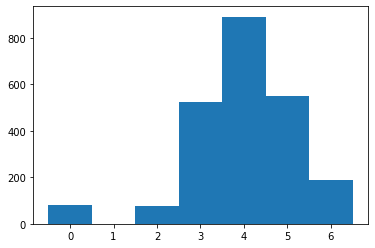

In [ ]:
# View simulation result
simulation_df = pd.DataFrame({'Victory': sim1_victory_list,
                              'Attempt Used': sim1_attempt_used_list})

simulation_df.head()

print('Simulation using IG + ML Score')
print('Win Rate:', round(sum(simulation_df['Victory']) / simulation_df.shape[0] * 100, 4), '%')
print('Attempt Used Average:', round(sum(simulation_df['Attempt Used']) / sum(simulation_df['Victory']), 4))
print()

# Print count of how many attempts were used to solve the game; 0 means it failed (didn't find the answer within 6 attempts)
attempt_count = simulation_df.value_counts(subset=['Attempt Used'], sort=False)
print(attempt_count)
print()

# Plot histogram showing the counts
pyplot.hist(simulation_df['Attempt Used'], bins=np.arange(-0.5, 7, 1))

In [ ]:
print(sim1_lost_list)

['baste', 'staid', 'batch', 'mucky', 'bough', 'waver', 'catty', 'ditty', 'pinch', 'jolly', 'shave', 'merry', 'marry', 'gusty', 'ferry', 'catch', 'vapor', 'woozy', 'guppy', 'puppy', 'trope', 'frock', 'fizzy', 'embed', 'gummy', 'tatty', 'daunt', 'papal', 'booby', 'goner', 'spear', 'drawl', 'taffy', 'tripe', 'boxer', 'vaunt', 'wight', 'golly', 'wound', 'saner', 'foist', 'parry', 'frown', 'bobby', 'creak', 'hunch', 'cower', 'eking', 'sappy', 'plunk', 'hitch', 'joker', 'mound']


After running simulations, we see on average the Wordle Solver can guess the right answer using a little over 4, this is good.

However it failes to solve the game sometimes. This is troubling.

# To Do

- Solver: if there's one result, tell user it's the only answer
- Solver: if there is 0 result (meaning there is a mistake), go back to last step
- Try to implement code that prevents guess from being cornered
- Try finding more features to improve Machine Learning score (for example, vulgar swear words are probably not answers, or brand names with almost no meaning)
- Try different scoring methods, such as ML score * IG score instead of adding
